In [ ]:
!pip3 install tensorflow numpy matplotlib keras opencv-python

In [ ]:
'''
To Extract data from zipfile
import zipfile
zip_ref=zipfile.ZipFile('/content/Dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()
'''


In [ ]:
# Importing dependencies
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#**PLOT RANDOM DATA FROM A DIRECTORY**

In [ ]:
def plot_images_from_directory(directory_path, class_actors, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_actors}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


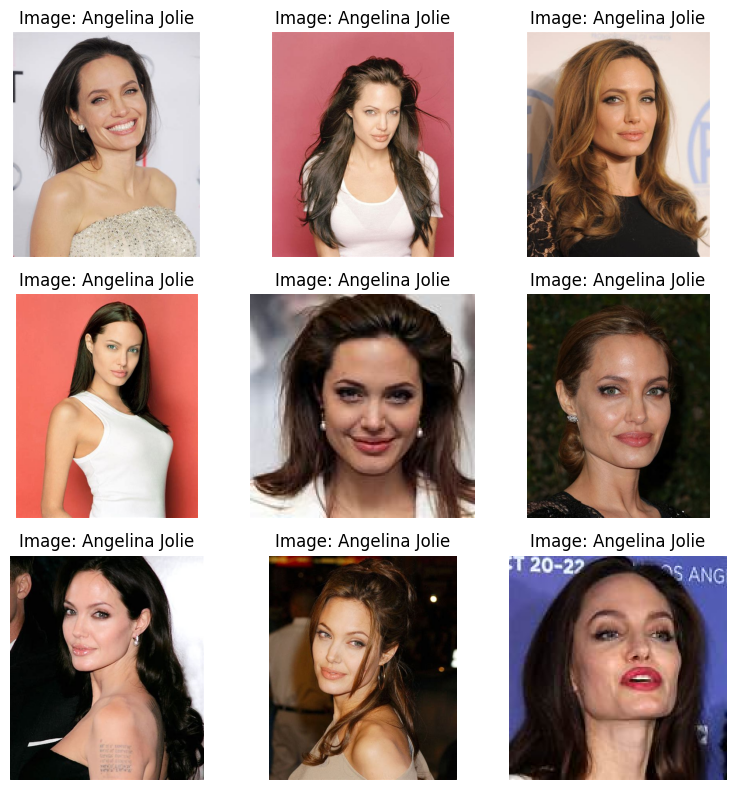

In [ ]:
plot_images_from_directory(directory_path='/content/Dataset/train/Angelina Jolie',class_actors='Angelina Jolie')

# **ANALYSING A DATASET**

In [ ]:
Angelina_Jolie_directory_path='/content/Dataset/train/Angelina Jolie'
Robert_Downey_Jr_directory_path='/content/Dataset/train/Robert Downey Jr'
Tom_Cruise_directory_path='/content/Dataset/train/Tom Cruise'


In [ ]:
Angelina_Jolie_images = os.listdir(Angelina_Jolie_directory_path)
Robert_Downey_Jr_images = os.listdir(Robert_Downey_Jr_directory_path)
Tom_Cruise_images = os.listdir(Tom_Cruise_directory_path)

classes_names = ['Angelina_Jolie', 'Robert_Downey_Jr','Tom_Cruise']
count = [len(Angelina_Jolie_images), len(Robert_Downey_Jr_images), len(Tom_Cruise_images)]

print(count)

[80, 80, 80]


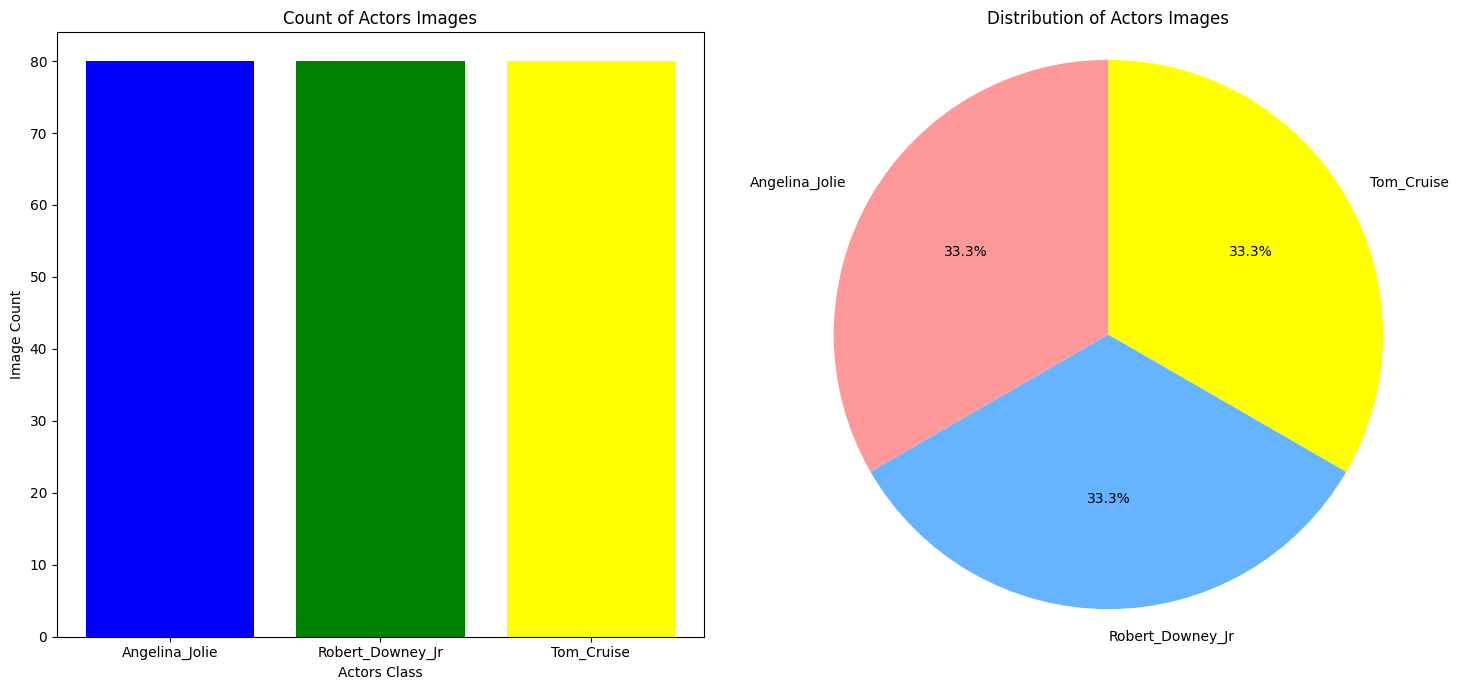

In [ ]:
# Creating both a bar chart and a pie chart side by side in a single figure

# Setting up a figure and axes for two subplots: one for the bar chart, one for the pie chart
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar chart on the first subplot
ax[0].bar(classes_names, count, color=['blue', 'green','yellow'])
ax[0].set_xlabel('Actors Class')
ax[0].set_ylabel('Image Count')
ax[0].set_title('Count of Actors Images')

# Pie chart on the second subplot
colors = ['#ff9999','#66b3ff','#FFFF00']
ax[1].pie(count, labels=classes_names, colors=colors, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Distribution of Actors Images')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust the layout so that both subplots fit nicely
plt.tight_layout()
plt.show()

# **REMOVING CORRUPTED IMAGES**

In [ ]:
import os
import cv2
import imghdr

# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/Dataset'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# **GENARATING DATASET FROM DIRECTORY**

In [ ]:
# Set path to the dataset
base_dir = '/content/Dataset/train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
# Load and augment data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode='categorical',
    subset='validation'
)

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


# **PLOTING IMAGE FROM GENERATOR**

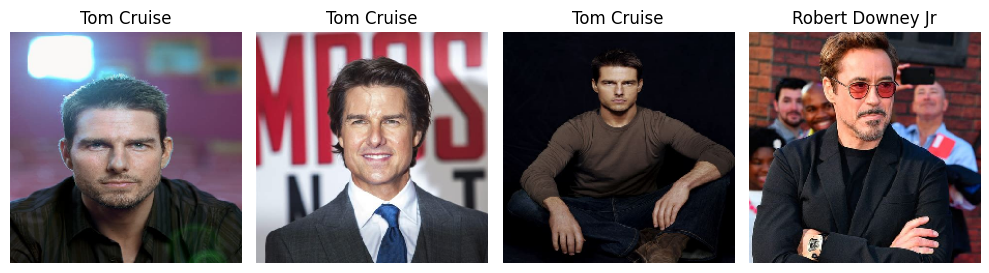

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(10,10))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # Image preprocessing might differ, adjust accordingly
        ax.imshow(img)
        # Set the title to the class label
        # Inverse the class indices dictionary to get class names from labels
        class_label = dict((v,k) for k,v in generator.class_indices.items())
        i = list((label)).index(1)
        ax.set_title(class_label.get(i))

        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Now, call this function with your training generator
plot_images_from_generator(train_generator, num_images=4)

In [ ]:
train_generator.reset()

# **USING TRANSFER LEARNING**

In [ ]:
# Load the MobileNetV2 model with pretrained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(500, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=4,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/4
10/10 [==============================] - 16s 1s/step - loss: 1.4711 - accuracy: 0.4531 - val_loss: 0.6777 - val_accuracy: 0.7500
Epoch 2/4
10/10 [==============================] - 12s 1s/step - loss: 0.3950 - accuracy: 0.8542 - val_loss: 0.4241 - val_accuracy: 0.7917
Epoch 3/4
10/10 [==============================] - 12s 1s/step - loss: 0.2254 - accuracy: 0.9375 - val_loss: 0.2802 - val_accuracy: 0.8750
Epoch 4/4
10/10 [==============================] - 8s 886ms/step - loss: 0.1547 - accuracy: 0.9479 - val_loss: 0.2434 - val_accuracy: 0.9375


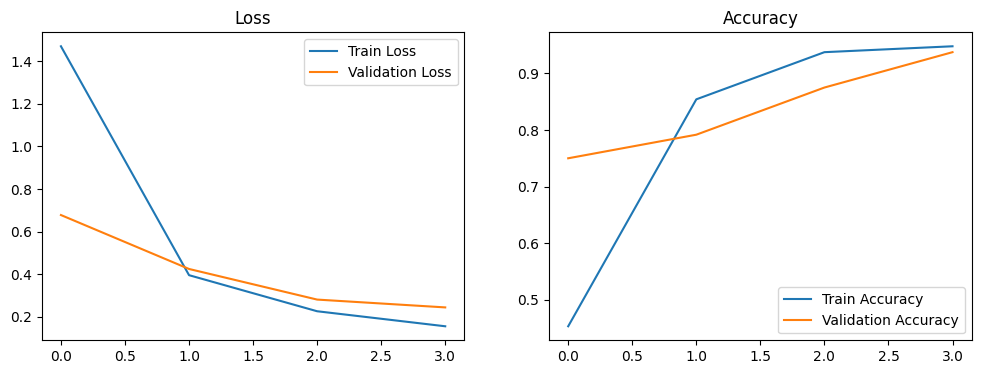

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# **MODEL EVALUATION**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

test_dir = '/content/Dataset/test'  # Path to your test directory

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Should match the input size of your network
    batch_size=20,  # Can adjust based on your memory constraints
    class_mode='categorical',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=False)

Found 63 images belonging to 3 classes.


In [ ]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Training Loss: {train_loss*100:.2f}%')
print(f'Training Accuracy: {train_accuracy*100:.2f}%')

val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss*100:.2f}%')
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Testing Loss: {test_loss*100:.2f}%')
print(f'Testing Accuracy: {test_accuracy*100:.2f}%')


10/10 [==============================] - 15s 2s/step - loss: 0.0977 - accuracy: 0.9844
Training Loss: 9.77%
Training Accuracy: 98.44%
3/3 [==============================] - 2s 675ms/step - loss: 0.2434 - accuracy: 0.9375
Validation Loss: 24.34%
Validation Accuracy: 93.75%
4/4 [==============================] - 4s 801ms/step - loss: 0.5034 - accuracy: 0.7778
Testing Loss: 50.34%
Testing Accuracy: 77.78%


In [ ]:
# Get the true labels
test_generator.reset()
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [ ]:
test_generator.reset()
predictions = model.predict_generator(test_generator)

y_pred = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print(class_labels)

print(confusion_matrix(test_generator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

<ipython-input-44-35bc373d805b>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


['Angelina Jolie', 'Robert Downey Jr', 'Tom Cruise']
[[21  0  0]
 [ 0 16  5]
 [ 1  8 12]]
                  precision    recall  f1-score   support

  Angelina Jolie       0.95      1.00      0.98        21
Robert Downey Jr       0.67      0.76      0.71        21
      Tom Cruise       0.71      0.57      0.63        21

        accuracy                           0.78        63
       macro avg       0.78      0.78      0.77        63
    weighted avg       0.78      0.78      0.77        63



# **PLOTING CONFUSION MATRIX**

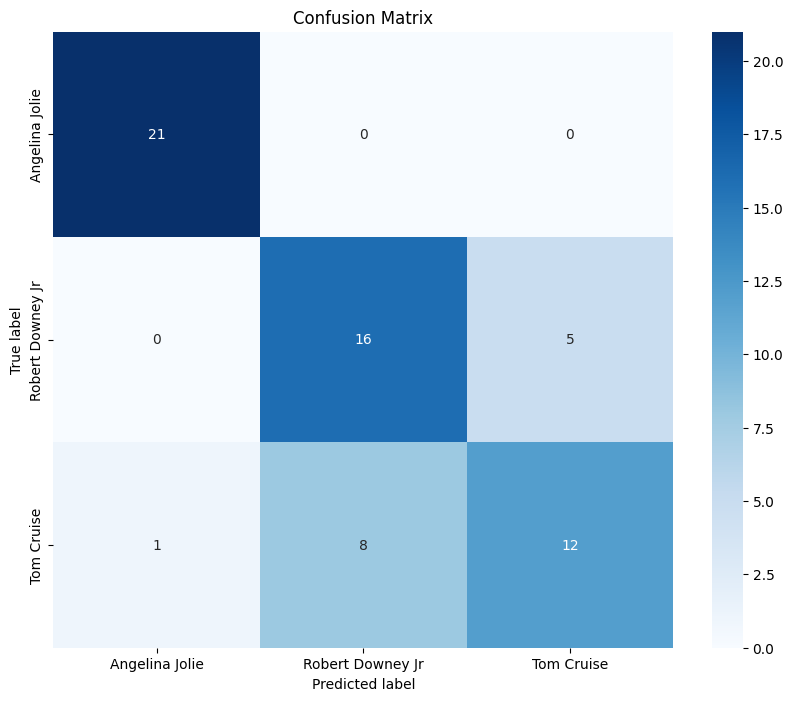

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Reset the test_generator before making predictions
test_generator.reset()

# Predict the whole test set
predictions = model.predict(test_generator, verbose=1)

# The predictions will be in the format of probabilities. You'll need to convert these to binary labels (0 or 1) based on a 0.5 threshold.
predicted_classes =np.argmax(predictions, axis=1)
true_classes = test_generator.classes
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_count = len(misclassified_indices)
print(f"Total misclassifications in the test set: {misclassified_count} out of {len(true_classes)}")

4/4 [==============================] - 6s 1s/step
Total misclassifications in the test set: 14 out of 63


# **PREDICTING IDENTITY OF A PERSON**

In [ ]:
# Function to predict the identity of person
def predict_identity(image_path, model, class_indices):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[predicted_class]

    return predicted_label

# Example prediction
image_path = '/content/Dataset/test/Angelina Jolie/092_26130bb1.jpg'
predicted_identity = predict_identity(image_path, model, train_generator.class_indices)
print(f'Predicted Identity: {predicted_identity}')

1/1 [==============================] - 1s 1s/step
Predicted Identity: Angelina Jolie


# **WOKING DESCRIPTION**
### 1.I USE FACIAL DATASET FROM KAGGLE AND MODIFIED IT TO 3 CLASSES
###2.THEN I COMPLETELY ANALYSE DATA DOMAIN AND FOUND THAT IT IS COMPLETLY BALANCED
###3.THEN I REMOVED CORRUPTED IMAGES THAT ARE FAILED TO OPEN
###4.THEN I PERFORM DATA AUGMENTATION USING IMAGEDATAGENERATOR
###5.AFTER THAT I USE TRANSFER LEARNING BY USING MOBILENETV2
###6.THEN I TRAINED A MODEL WITH TRAINING ACCURACY OF 98% AND TESTING ACCURACY OF 80% DUE TO HAVING LESS NUMBER OF DATA
###7.THEN PLOT CONFUSION MATRIX
###8.THEN EVALUATE A MODEL BY PRECISION,RECALL,F1SCORE
###9.THEN TEST IT WITH RANDOM DATA AND IT PREDICT CORRECTLY
###10.THEN CALCULATE NUMBER OF MISCLASSIFICATION AND FOUND 12 OUT OF 60 ARE MISCLASSIFIED


